In [1]:
import os
import numpy as np
from keras import layers
from keras.datasets import mnist
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.models import Model
from keras.initializers import glorot_uniform

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
y_train_onehot = to_categorical(y_train, num_classes=None, dtype='float32')
print("Train Set Size = {} images".format(y_train.shape[0]))
print("Test Set Size = {} images".format(y_test.shape[0]))

Train Set Size = 60000 images
Test Set Size = 10000 images


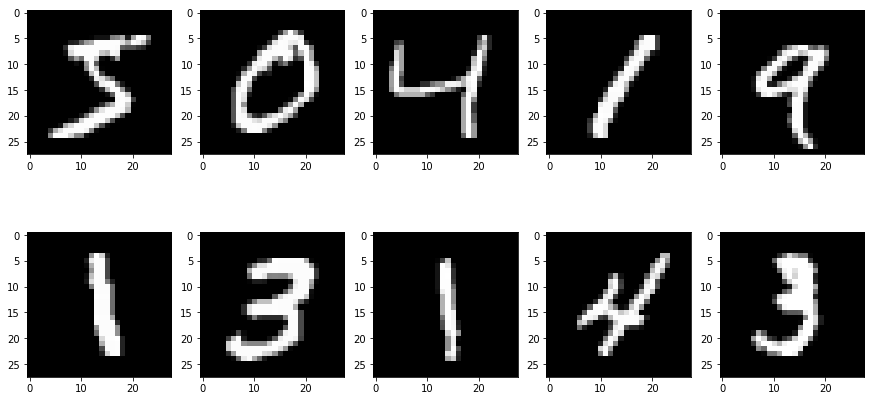

Labels : [5 0 4 1 9]
Labels : [1 3 1 4 3]


In [3]:
fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(x_train[i], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(x_train[i+6], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("Labels : {}".format(y_train[0:5]))
print("Labels : {}".format(y_train[6:11]))

In [4]:
optimizer = 'adam'
objective = 'categorical_crossentropy'

def identity_block(X, f, filters, stage, block):
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(1,1), padding='valid', name=conv_name_base+'2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding='same', name=conv_name_base+'2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding='valid', name=conv_name_base+'2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2c')(X)

    X = layers.Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, stage, block, s=2):
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(s,s), name=conv_name_base+'2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding='same', name=conv_name_base+'2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), name=conv_name_base+'2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2c')(X)

    X_shortcut = Conv2D(F3, kernel_size=(1,1), strides=(s,s), name=conv_name_base+'1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base+'1')(X_shortcut)

    X = layers.Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


def resNet():
    
    # Define the input as a tensor with shape input_shape
    X_input = Input((28,28,1))
    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1',)(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    
    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')
    
    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    
    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    
    # AVGPOOL
    # X = AveragePooling2D((2,2), name='avg_pool')(X)
    
    # output layer
    X = Flatten()(X)
    X = Dense(y_train_onehot.shape[1], activation='softmax', name='fc' + str(y_train_onehot.shape[1]))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')
    
    #Compile the model
    model.compile(optimizer=optimizer, loss=objective, metrics=['accuracy'])
    
    return model

In [5]:
model = resNet()

In [6]:
nb_epoch = 50
batch_size = 128

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))

early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1, mode='auto')

def run_resNet():
    
    history = LossHistory()
    # x_train & x_test reshaped because of single channel !
    model.fit(x_train.reshape((-1,28,28,1)), y_train_onehot, batch_size=batch_size, epochs=nb_epoch,
              validation_split=0.25, verbose=1, shuffle=True, callbacks=[history, early_stopping])
    

    predictions = model.predict(x_test.reshape((-1,28,28,1)), verbose=0)
    return predictions, history

def test_accuracy():
    err = []
    t = 0
    for i in range(predictions.shape[0]):
        if (np.argmax(predictions[i]) == y_test[i]):
            t = t+1
        else:
            err.append(i)
    return t, float(t)*100/predictions.shape[0], err

In [7]:
predictions, history = run_resNet()

Train on 45000 samples, validate on 15000 samples
Epoch 1/50
45000/45000 [==============================] - 41s 915us/step - loss: 0.3206 - acc: 0.9127 - val_loss: 0.1556 - val_acc: 0.9541
Epoch 2/50
45000/45000 [==============================] - 28s 617us/step - loss: 0.0672 - acc: 0.9796 - val_loss: 0.0797 - val_acc: 0.9760
Epoch 3/50
45000/45000 [==============================] - 28s 615us/step - loss: 0.0477 - acc: 0.9848 - val_loss: 0.0812 - val_acc: 0.9770
Epoch 4/50
45000/45000 [==============================] - 28s 616us/step - loss: 0.0385 - acc: 0.9884 - val_loss: 0.0953 - val_acc: 0.9757
Epoch 5/50
45000/45000 [==============================] - 28s 616us/step - loss: 0.0348 - acc: 0.9890 - val_loss: 0.0729 - val_acc: 0.9792
Epoch 6/50
45000/45000 [==============================] - 28s 616us/step - loss: 0.0255 - acc: 0.9917 - val_loss: 0.1011 - val_acc: 0.9764
Epoch 7/50
45000/45000 [==============================] - 28s 611us/step - loss: 0.0306 - acc: 0.9909 - val_loss: 2.

In [8]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 34, 34, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 14, 14, 64)   3200        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 14, 14, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

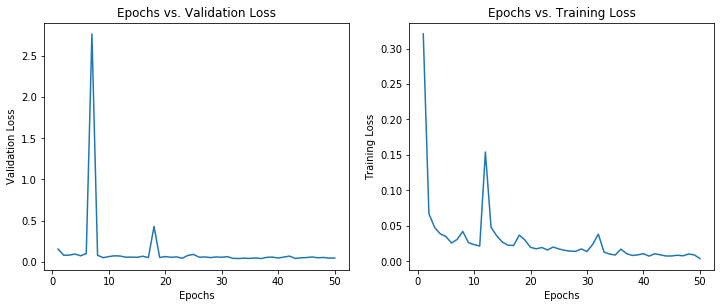

In [9]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,nb_epoch+1), history.val_losses)
ax1.set(xlabel='Epochs', ylabel='Validation Loss',
       title='Epochs vs. Validation Loss')
ax2.plot(np.arange(1,nb_epoch+1), history.losses)
ax2.set(xlabel='Epochs', ylabel='Training Loss',
       title='Epochs vs. Training Loss')
plt.show()

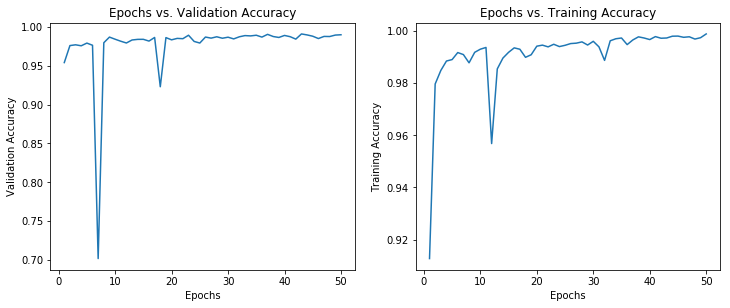

In [10]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,nb_epoch+1), history.val_acc)
ax1.set(xlabel='Epochs', ylabel='Validation Accuracy',
       title='Epochs vs. Validation Accuracy')
ax2.plot(np.arange(1,nb_epoch+1), history.acc)
ax2.set(xlabel='Epochs', ylabel='Training Accuracy',
       title='Epochs vs. Training Accuracy')
plt.show()

Test accuracy: 99.16 %


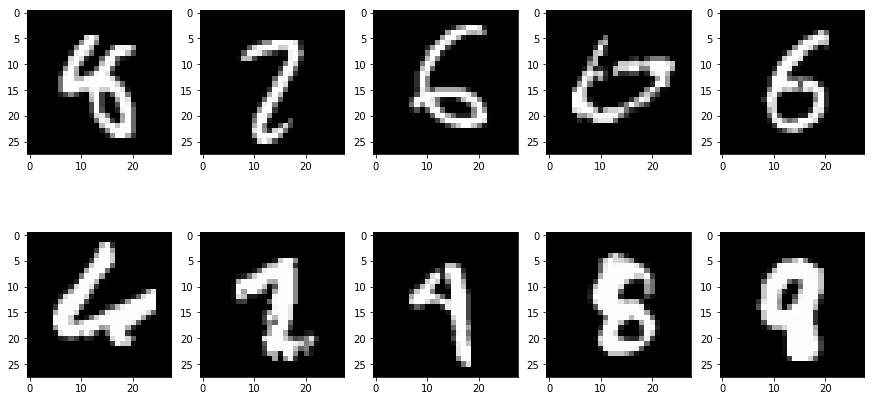

True:          [8 2 6 6 6]
classified as: [5 7 5 0 5]
True:          [6 2 4 8 8]
classified as: [4 1 9 5 9]


In [11]:
p = test_accuracy()
print("Test accuracy: {} %".format(p[1]))

fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(x_test[p[2][i]], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(x_test[p[2][i+6]], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("True:          {}".format(y_test[p[2][0:5]]))
print("classified as: {}".format(np.argmax(predictions[p[2][0:5]], axis=1)))

print("True:          {}".format(y_test[p[2][6:11]]))
print("classified as: {}".format(np.argmax(predictions[p[2][6:11]], axis=1)))